# Data Analytics Tech Challenge - Fase 2 Machine Learning and Data Analytics

## Grupo 41

- [André Guilherme Corrêa](https://www.linkedin.com/in/agcorrea/)
- [Letícia Maia de Oliveira](https://www.linkedin.com/in/lemaia/)
- [Nathalia Souza Vaz](https://www.linkedin.com/in/sousanathalias/)
- [Renan Felipe Silva](https://www.linkedin.com/in/renan-silva-16960313a)

## O Problema

Imagine que você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados da IBOVESPA (Bolsa de valores) para criar uma série temporal e prever diariamente o fechamento da base.

Para isso utilize a base de dados contida no [site da investing](https://br.investing.com/indices/bovespa-historical-data) e selecione o período “diário”, com o intervalo de tempo que achar adequado.

Você precisará demonstrar para o time de investimentos:

1. O modelo com o storytelling, desde a captura do dado até a entrega do modelo;
2. Justificar a técnica utilizada;
3. Atingir uma acuracidade adequada (acima de 70%).

> DICA: Utilize o maior intervalo de tempo possível para atingir maior acuracidade no modelo preditivo.

## Dicionário de dados

- Data:
- Último: preço do índice no fechamento
- Abertura: preço do índice na abertura do mercado
- Máxima: maior preço durante o dia
- Mínima: menor preço durante o dia
- Vol.: volume de negociações
- Var%: variação do preço entre a abertura e o fechamento

In [1]:
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Captura dos dados

### Importação inicial

In [2]:
# Lendo dados da fonte externa para que todos consigam rodar o código no Colab sem ter que fazer upload do arquivo
# Mantendo Dataframe original para facilitar rodar as transformações multiplas vezes
df_raw = pd.read_csv(
    'https://raw.githubusercontent.com/agcorrea/fiap-techchallenge-grupo41/main/fase-2/dados/ibovespa_2003-01-01_2023-03-09.csv',
    parse_dates=['Data'], dayfirst=True,
    thousands='.', decimal=',')
df_raw.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2023-03-09,105071,106540,106724,105053,"19,17M","-1,38%"
1,2023-03-08,106540,104228,106721,104228,"15,90M","2,22%"
2,2023-03-07,104228,104700,105179,103480,"12,58M","-0,45%"
3,2023-03-06,104700,103865,105171,103170,"14,28M","0,80%"
4,2023-03-03,103866,103326,104440,103323,"13,10M","0,52%"


In [3]:
df_raw.dtypes

Data        datetime64[ns]
Último               int64
Abertura             int64
Máxima               int64
Mínima               int64
Vol.                object
Var%                object
dtype: object

As colunas `Data`, `Último`, `Abertura`, `Máxima` e `Mínima` foram corretamente parseadas com os parâmetros do `pd.read_csv`.

Teremos que tratar as colunas `Vol.` e `Var%` para que se tornem númericas.

### Transformações

No arquivo CSV baixado do site investing.com, os valores das colunas `Vol.` e `Var%` estão formatados como texto.



In [4]:
# Explorando quais unidades estão presentes na coluna Vol.
df_raw['Vol.'].str.replace('\d', '', regex=True).unique()

array([',M', ',K', nan], dtype=object)

In [5]:
f"Porcentagem de valores da coluna `Var%` que terminam com %: {len(df_raw[df_raw['Var%'].str.endswith('%')]) / len(df_raw) * 100}%"

'Porcentagem de valores da coluna `Var%` que terminam com %: 100.0%'


O código à seguir transforma as colunas para seus respectivos valores numéricos.

*   `Vol.`: os valores estão representados com os símbolos M e K que significam milhões e milhares, respectivamente.
*   `Var%`: os valores estão representados com o símbolo de porcentagem e separador decimal `,`.



In [6]:
# Função para transformar a coluna `Vol.` de texto para números inteiros
def parse_vol(x):
  # Não faz nada caso não seja uma string
  if type(x) != str:
    return None

  # Multiplica por 1 milhão se possuí símbolo M ou por 1 mil se símbolo K
  multiplier = 1_000_000 if x.endswith('M') else 1_000

  # Remove o símbolo M ou K
  result = x[:-1]

  # Altera o separador para . ao invés de ,
  result = result.replace(',', '.')
  # Transforma a string em número
  result = float(result)

  # Multiplica o número pelo multiplicador e transforma em inteiro
  return int(result * multiplier)

In [7]:
# Função para transformar a coluna `Var%` de texto para número decimal
def parse_var(x):
  # Remove o símbolo de %
  result = x[:-1]

  # Altera o separador para . ao invés de ,
  result = result.replace(',', '.')

  # Transforma a string em número
  result = float(result)

  # Transforma em porcentagem
  return result / 100

In [8]:
# Cria um novo DataFrame a partir dos dados crus para aplicar as transformações
df = df_raw.copy()
df['Vol.'] = df['Vol.'].apply(parse_vol)
df['Var%'] = df['Var%'].apply(parse_var)
df = df.set_index('Data', drop=True)
df = df.sort_index()
df.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2003-01-02,11603,11291,11603,11291,195130000.0,0.0297
2003-01-03,11600,11632,11798,11600,197050000.0,-0.0002
2003-01-06,12020,11636,12032,11633,398400000.0,0.0362
2003-01-07,11876,12010,12018,11842,387980000.0,-0.0119
2003-01-08,11786,11875,11928,11757,217190000.0,-0.0076


In [9]:
df.dtypes

Último        int64
Abertura      int64
Máxima        int64
Mínima        int64
Vol.        float64
Var%        float64
dtype: object

Após as transformações, todos os tipos estão corretos.

### Dados faltantes

Neste bloco, os dados faltantes serão encontrados e tratados caso necessário.

In [10]:
# Quantidade de valores nulos por coluna
df.isnull().sum()

Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

Temos um único valor nulo na coluna `Vol.`.

In [11]:
# Filtra dataframe procurando por valores nulos na coluna Vol.
df[df.isnull()['Vol.'] == True]

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2016-02-10,40377,40592,40592,39960,NaN,-0.0053


Segundo o site [Yahoo! Finance](https://yhoo.it/3P3HaYv), no dia 10/02/2016 ocorreu um volume de movimentações de 3.70M.

![ibovespa_2016-02-10.png](https://raw.githubusercontent.com/agcorrea/fiap-techchallenge-grupo41/main/fase-2/assets/ibovespa_2016-02-10.png)

In [12]:
# Atualiza o valor nulo com o encontrado no Yahoo! Finance
df.loc['2016-02-10', 'Vol.'] = 3.7 * 1_000_000
df[df.index == '2016-02-10']

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2016-02-10,40377,40592,40592,39960,3700000.0,-0.0053


In [13]:
print('Teste de sanidade, nenhum valor deve ser nulo:')

# Quantidade de valores nulos por coluna
df.isnull().sum()

Teste de sanidade, nenhum valor deve ser nulo:


Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        0
Var%        0
dtype: int64

## Análise Exploratória dos Dados

A variável target, que iremos realizar a previsão será o preço de fechamento,  portanto a coluna ***Último***.

### Análise estatística

In [14]:
# Entendendo o tamanho da nossa base de dados
df.shape

(5000, 6)

In [15]:
#Analise estatística
df.describe()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
count,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03,5000.000000
mean,62253.400200,62235.375200,62871.646000,61601.993800,4.959029e+07,0.000595
std,28200.997062,28203.446595,28420.936536,27972.454981,1.029088e+08,0.017202
min,9995.000000,10006.000000,10151.000000,9968.000000,1.121000e+05,-0.147800
25%,45481.500000,45474.000000,45973.500000,45005.250000,2.830000e+06,-0.008500
50%,58080.000000,58072.500000,58617.000000,57524.000000,4.480000e+06,0.000900
75%,76035.500000,76017.750000,76690.000000,75303.750000,1.473250e+07,0.010125
max,130776.000000,130776.000000,131190.000000,129526.000000,9.949600e+08,0.146600


###Análise de distribuição

#### Histogramas

A nossa variável target, que vamos querer prever, são os ***preços de fechamamento***, ou seja, a coluna *Último*.

Desta forma, O primeiro passo será verificar como nossa varivel target está distribuida.

Para isso iremos plotar um **histograma** da coluna "*Ùltimo*" e realizar um ***teste de hipotese***.



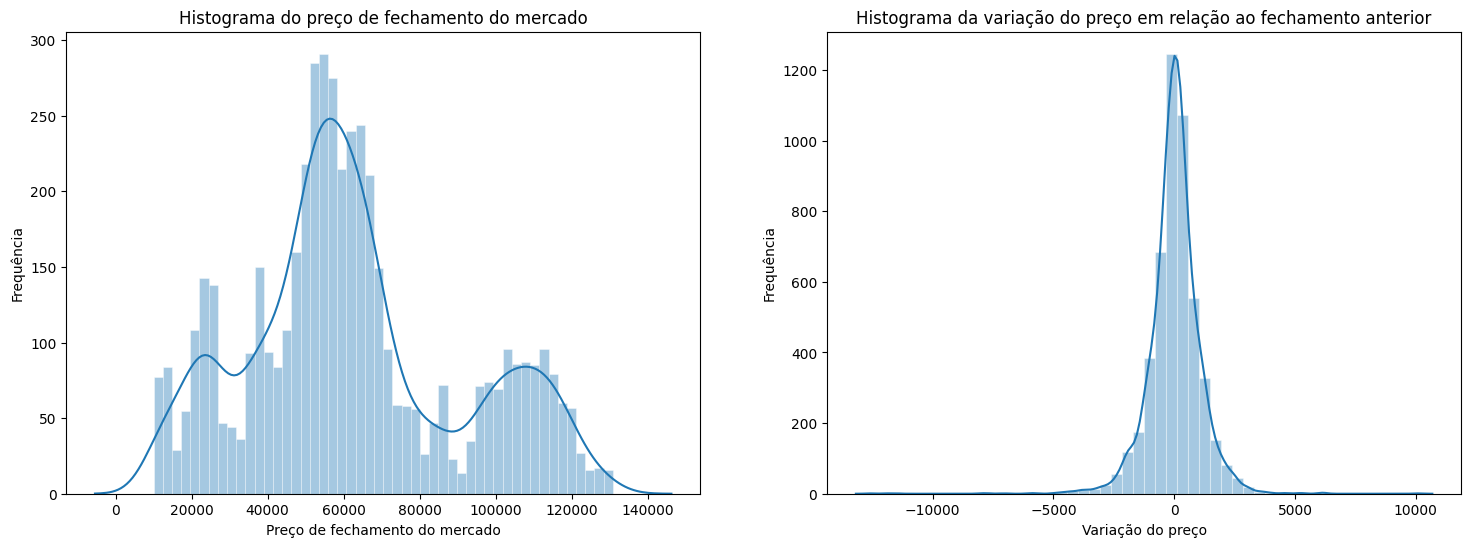

In [16]:
_, axes = plt.subplots(1, 2, figsize=(18,6))

# Histograma do preço de fechamento do mercado
ax = sns.histplot(
    df['Último'],
    ax=axes[0],
    kde=True, kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4),
    bins=50,
)
ax.set_title('Histograma do preço de fechamento do mercado')
ax.set_ylabel('Frequência')
ax.set_xlabel('Preço de fechamento do mercado')

# Histograma da variação do preço de fechamento do mercado
ax = sns.histplot(
    df['Último'].diff(1),
    ax=axes[1],
    kde=True, kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4),
    bins=50,
)
ax.set_title('Histograma da variação do preço em relação ao fechamento anterior')
ax.set_ylabel('Frequência')
ax.set_xlabel('Variação do preço')

plt.show()

#### Teste de normalidade

- Hipótese Nula: os dados seguem distribuição normal
- Hipótese Alternativa: os dados não seguem distribuição normal

Nível de confiança: 95%

In [17]:
from scipy.stats import normaltest

alpha = 0.05
k2, p = normaltest(df['Último'])

print('Teste de normalidade sobre o preço do fechamento')
if p < alpha:
    print('A Hipótese Nula pode ser rejeitada, ou seja, Distribuição NÃO é normal')
else:
    print('A hipótese nula não pode ser rejeitada, ou seja, a Distribuição é normal')

Teste de normalidade sobre o preço do fechamento
A Hipótese Nula pode ser rejeitada, ou seja, Distribuição NÃO é normal


In [18]:
from scipy.stats import normaltest

alpha = 0.05
k2, p = normaltest(df['Último'].diff(1))

print('Teste de normalidade sobre a variação do preço em relação ao fechamento anterior')
if p < alpha:
    print('A Hipótese Nula pode ser rejeitada, ou seja, Distribuição NÃO é normal')
else:
    print('A hipótese nula não pode ser rejeitada, ou seja, a Distribuição é normal')

Teste de normalidade sobre a variação do preço em relação ao fechamento anterior
A hipótese nula não pode ser rejeitada, ou seja, a Distribuição é normal


####Boxplot

Iremos analisar a distribuição dos dados separados por dois distintos grupos: altas e baixas. O boxplot nos permitirá visualizar a proporção de altas e quedas estão distrubuido de forma proporcional, garantindo que nosso  modelo terá dados suficientes para prever os dois cenários de forma efetiva. O boxplot também é uma excelente ferramenta para identificar outiliers.

In [19]:
#adicionando label 1 para alta e 0 para queda de acordo com a variação

In [20]:
condicoes = [(df['Var%'] < 0),
             (df['Var%'] > 0)]
opcoes = ["0","1"]
df['class_num'] = np.select(condicoes, opcoes)
df

,Último,Abertura,Máxima,Mínima,Vol.,Var%,class_num
Data,,,,,,,
2003-01-02,11603,11291,11603,11291,195130000.0,0.0297,1
2003-01-03,11600,11632,11798,11600,197050000.0,-0.0002,0
2003-01-06,12020,11636,12032,11633,398400000.0,0.0362,1
2003-01-07,11876,12010,12018,11842,387980000.0,-0.0119,0
2003-01-08,11786,11875,11928,11757,217190000.0,-0.0076,0
...,...,...,...,...,...,...,...
2023-03-03,103866,103326,104440,103323,13100000.0,0.0052,1
2023-03-06,104700,103865,105171,103170,14280000.0,0.0080,1
2023-03-07,104228,104700,105179,103480,12580000.0,-0.0045,0


In [21]:
condicoes = [(df['Var%'] < 0),
             (df['Var%'] == 0),
             (df['Var%'] > 0)]
opcoes = ["Baixa","Nulo","Alta"]
df['class_name'] = np.select(condicoes, opcoes)
df

,Último,Abertura,Máxima,Mínima,Vol.,Var%,class_num,class_name
Data,,,,,,,,
2003-01-02,11603,11291,11603,11291,195130000.0,0.0297,1,Alta
2003-01-03,11600,11632,11798,11600,197050000.0,-0.0002,0,Baixa
2003-01-06,12020,11636,12032,11633,398400000.0,0.0362,1,Alta
2003-01-07,11876,12010,12018,11842,387980000.0,-0.0119,0,Baixa
2003-01-08,11786,11875,11928,11757,217190000.0,-0.0076,0,Baixa
...,...,...,...,...,...,...,...,...
2023-03-03,103866,103326,104440,103323,13100000.0,0.0052,1,Alta
2023-03-06,104700,103865,105171,103170,14280000.0,0.0080,1,Alta
2023-03-07,104228,104700,105179,103480,12580000.0,-0.0045,0,Baixa


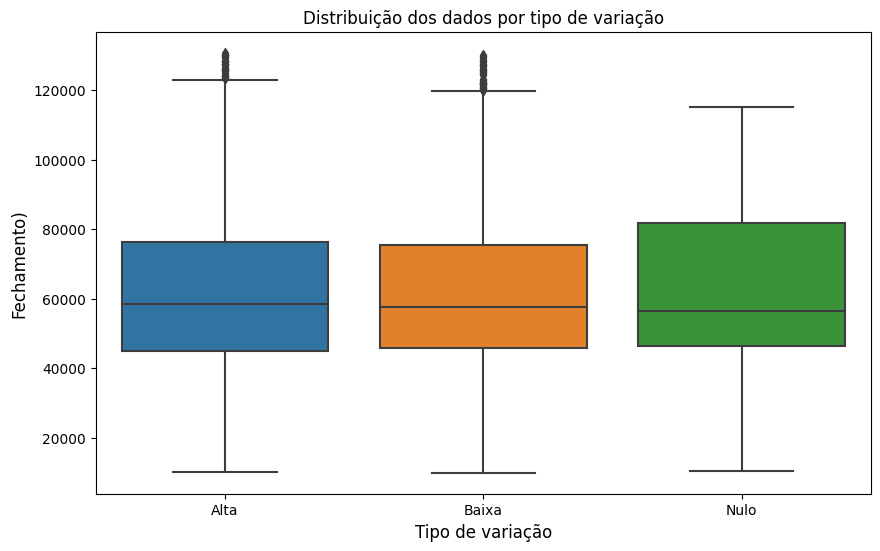

In [22]:
# definindo o tamanho do plot
fig, ax = plt.subplots(figsize = ( 10, 6 ))

# plotando o gráfico
sns.boxplot(x = 'class_name', y = 'Último', data = df)
ax.set_xlabel( "Tipo de variação" , size = 12 )
ax.set_ylabel( "Fechamento)" , size = 12 )

# definindo o título
plt.title("Distribuição dos dados por tipo de variação");

### Visualização de Séries temporais

Plotar a série temporal para analisar o comportamento ao longo do tempo


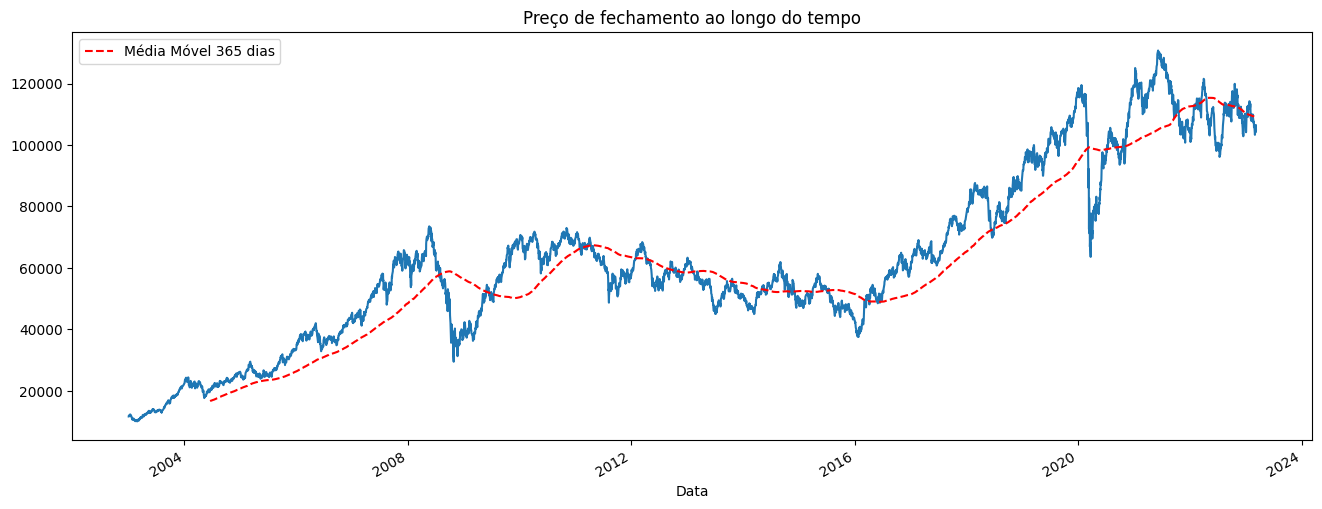

In [23]:
#Plotar a série temporal para analisar o comportamento ao longo do tempo
plt.figure(figsize = (16, 6))
df['Último'].plot()
df['Último'].rolling(365).mean().plot(color='r', style='--', label='Média Móvel 365 dias', legend=True)
plt.title("Preço de fechamento ao longo do tempo")
plt.show()

### Estacionariedade

> ADF test is used to determine the presence of unit root in the series, and hence helps in understand if the series is stationary or not. The null and alternate hypothesis of this test are:
>
> - Null Hypothesis: The series has a unit root.
> - Alternate Hypothesis: The series has no unit root.
>
> If the null hypothesis in failed to be rejected, this test may provide evidence that the series is non-stationary.

Fonte: https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

In [24]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print("Resultados do teste ADF\n")
    result = adfuller(timeseries)
    print(f"Teste Estatístico: {result[0]}")
    print(f"P-Value: {result[1]}")

    print("\nValores críticos:")
    for key, value in result[4].items():
        print("\t- %s:\t%s" % (key, value))

    print()
    if result[1] < 0.05:
      print('Hipótese nula rejeitada, portanto a série é estacionária.')
    else:
      print('A hipótese nula não foi rejeitada, portanto a série é não estacionária.')


In [25]:
adf_test(df['Último'])

Resultados do teste ADF

Teste Estatístico: -1.5832810982310113
P-Value: 0.4919863031170957

Valores críticos:
	- 1%:	-3.43166168173001
	- 5%:	-2.8621196211801374
	- 10%:	-2.5670785331097763

A hipótese nula não foi rejeitada, portanto a série é não estacionária.


## Modelo Preditivo

###Prophet

O Prophet é um modelo de regressão aditiva com uma parte linear ou curva de tendência de crescimento logístico. Este modelo possuim um componente sazonal anual modelado usando série Fourier e um componente sazonal semanal modelado usando variáveis fictícias.
Desta forma, iremos avaliar a acuracidade deste modelo para a previsão de séries temporais.

Fonte:
https://docs.aws.amazon.com/pt_br/forecast/latest/dg/aws-forecast-recipe-prophet.html



####Conhecendo modelo

In [26]:
#instalando a biblioteca do Prophet
!pip install prophet

In [27]:
#importando as bibliotecas que serão utilizadas
from prophet import Prophet


Nesta etapa  iremos  preparar nossos dados para aplicar a previsão  utilizando Prophet. O Prophet espera receber um dataframe com duas colunas. A primeira coluna deve-se chamar DS e contem das das da série temporal. A segunda coluna deve-se chama Y e conter os valores a serem previstos.



In [28]:
#  Criação de um  data frame padrão
df_prophet = df.copy()
df_prophet= df_prophet.drop(columns=["Abertura","Máxima", "Vol.", "Var%", "Mínima","class_num","class_name"])

# verificando as primeiras 5 linhas
df_prophet.head()


,Último
Data,
2003-01-02,11603
2003-01-03,11600
2003-01-06,12020
2003-01-07,11876
2003-01-08,11786


In [29]:
# renomeando as colunas
df_prophet.index.rename('ds', inplace=True)
df_prophet = df_prophet.rename(columns={'Último': 'y'})
df_prophet['ds'] = df.index
df_prophet.head()

,y,ds
ds,,
2003-01-02,11603,2003-01-02
2003-01-03,11600,2003-01-03
2003-01-06,12020,2003-01-06
2003-01-07,11876,2003-01-07
2003-01-08,11786,2003-01-08


Similar ao procedimento que utilizamos para a biblioteca scikit-learn sklearn, deveremos criar uma instância do modelo e posteriormente realizar o treinamento (fit) do modelo.:

In [30]:
# instanciando o modelo
m = Prophet(yearly_seasonality=True)

# realizando o treinamento
m.fit(df_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzxic7jw/l5syl0j4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzxic7jw/9dbax9pz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15171', 'data', 'file=/tmp/tmpbzxic7jw/l5syl0j4.json', 'init=/tmp/tmpbzxic7jw/9dbax9pz.json', 'output', 'file=/tmp/tmpbzxic7jw/prophet_modelg0cygtgg/prophet_model-20230828004815.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:48:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:48:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Agora iremos definir o período no qual queremos que  modelo faça a previsão. Para isso o Prophet disponibiliza um dataframe adequado que se estende para o futuro pelo número especifico de dias que queremos prever.  Podemos fazer istp através do  método  ***make_future_dataframe***.

In [31]:
# método auxiliar para previsão
future = m.make_future_dataframe(periods = 365)
# previsão do modelo
forecast = m.predict(future)

Dataframe de resultados do treinamento

No Dataframe gerado a coluna yhat representa as previsões. Já as colunas  yhat_lower e yhat_upper são as componentes do intervalo de incertezas.  Desta foma, uanto mais distante o tempo à frente, mais incerto fica a previsão.



In [32]:
# verificando as primeiras 5 linhas
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2003-01-02,11798.384399,4266.471844,19889.129445
1,2003-01-03,11903.059698,4417.533115,19695.531003
2,2003-01-06,12143.060157,4222.078635,19971.263180
3,2003-01-07,12252.054542,3992.388964,19792.643151
4,2003-01-08,12360.365197,5199.926581,19803.612818


Agora vamos treinar o modelo para conseguir analisar os resultados. Como essa é apenas uma validação do modelo, ainda não iremos nos preocupar en dividir a base de dados para treinamento e teste. Isto será realizado em etapas futuras.

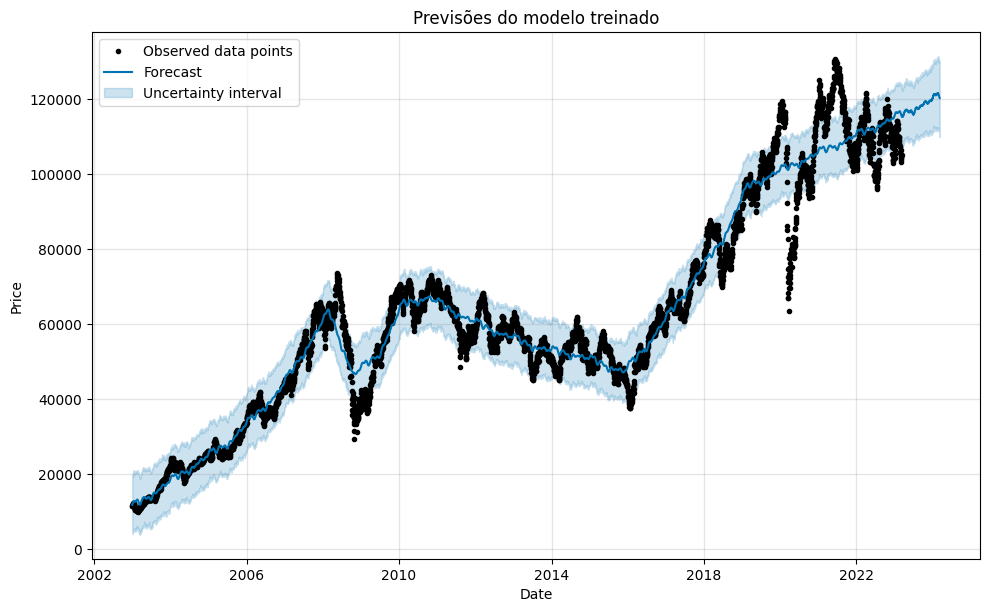

In [33]:
# previsões do modelo treinado
figure = m.plot(forecast, xlabel = 'Date', ylabel = 'Price')
plt.title("Previsões do modelo treinado")
plt.legend()

Podemos visualizar também os componentes da previsão de forma independente:

*   Trend (tendência)
*   yearly seasonality(sazonalidade anual)
*   Weekly seasonality(sazonalidade semanal)

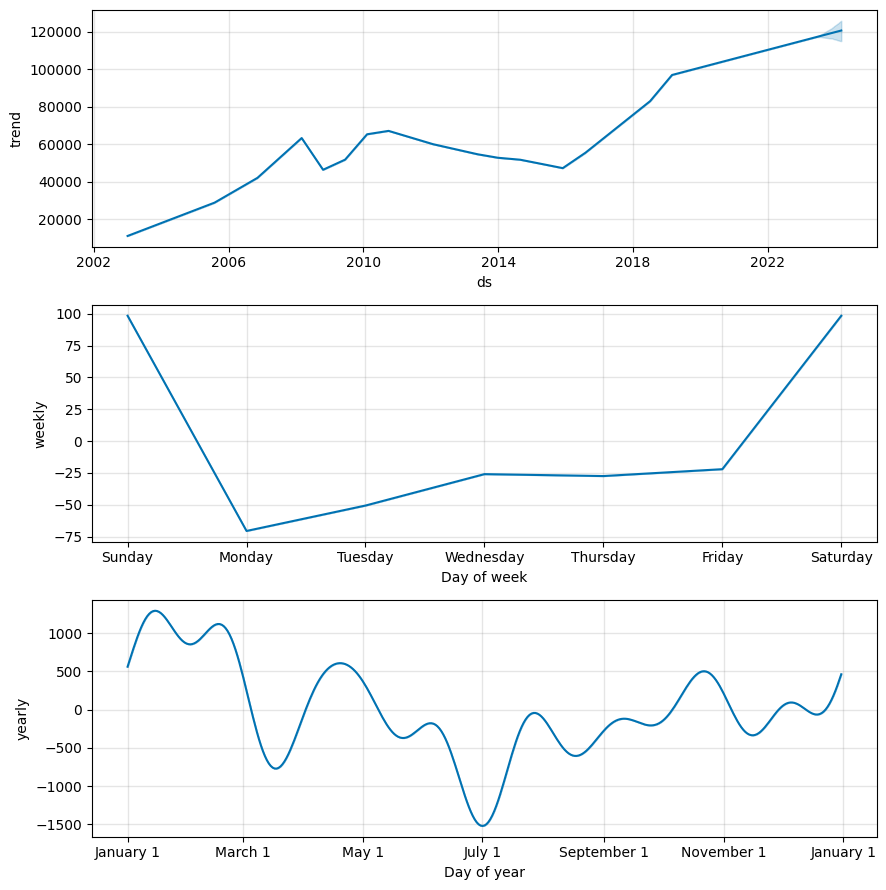

In [34]:
# verificando os componentes
figure2 = m.plot_components(forecast)

Agora que já conhecemos o modelos e identificamos e as previsões realizadas em nossa base de dados estão próximos dos nossos imputs reais. Iremos iniciar a construção do nosso modelo de previsão.

####Preparação os dados

Nesta próxima etapa iremos separar os dados que serão utilizados para teste e para treinamento.

In [35]:
# definindo uma data de corte
data_fim = '2021-08-20'
# definindo os dados de treino, antes da data de corte
train = df_prophet.loc[df_prophet['ds'] <= data_fim]
# definindo os dados de teste posterior a data de corte
test = df_prophet.loc[df_prophet['ds'] > data_fim]

In [36]:
# contando a quantidade de dias à frente para posteriormente checarmos a acurácia da previsão
dias_a_prever = len(test.ds.unique())
# checando a quantidade de dias
dias_a_prever

386

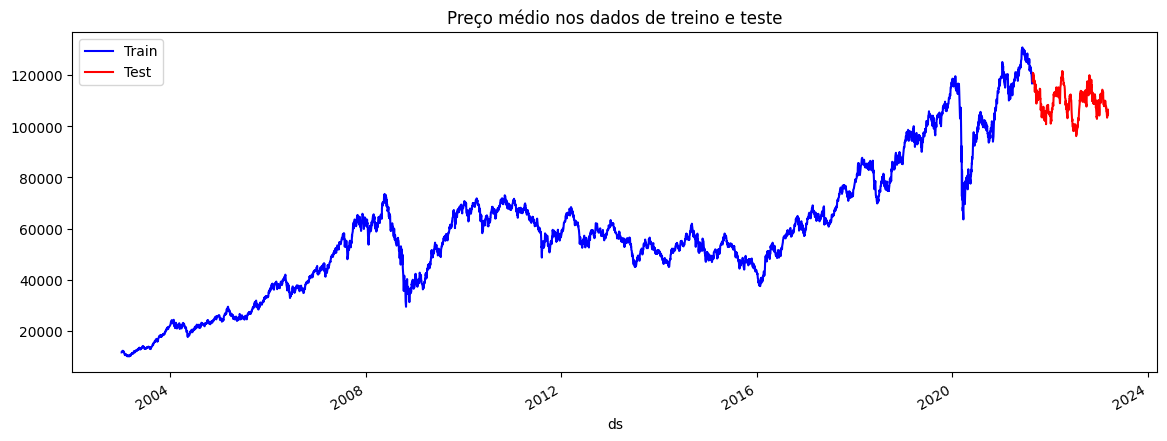

In [37]:
# definindo o tamanho do plot
f, ax = plt.subplots(figsize=(14,5))
# plotando os dados de treino
train.plot(kind='line', x='ds', y='y', color='blue', label='Train', ax=ax)
# plotando os dados de teste
test.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
# definindo o título
plt.title('Preço médio nos dados de treino e teste');

In [38]:
# criando a função MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)*100
    return np.mean(np.abs((y_true - y_pred) / y_true))

####Treinamento do Modelo

In [39]:
# instanciando o modelo
m = Prophet(yearly_seasonality=True)
# realizando o treinamento
#m = Prophet(changepoint_prior_scale=0.01)
m.fit(train)
# método auxiliar para previsão
future = m.make_future_dataframe(periods=dias_a_prever)
# previsão do modelo
forecast = m.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzxic7jw/ezl9js29.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzxic7jw/5s5xip15.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18526', 'data', 'file=/tmp/tmpbzxic7jw/ezl9js29.json', 'init=/tmp/tmpbzxic7jw/5s5xip15.json', 'output', 'file=/tmp/tmpbzxic7jw/prophet_modelx6o3m_zj/prophet_model-20230828004820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:48:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:48:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Dataframe de resultados do treinamento

In [40]:
# olhando os resultados das previsões com os dados de treino
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4995,2022-09-06,131901.898483,120818.607311,142650.093009
4996,2022-09-07,131996.699665,121391.808494,142519.230877
4997,2022-09-08,132079.871075,120683.451727,142417.047278
4998,2022-09-09,132144.922336,120877.761674,142601.749195
4999,2022-09-10,132664.247193,121376.925080,143294.393526


#####Componentes de sazonalidade e tendência

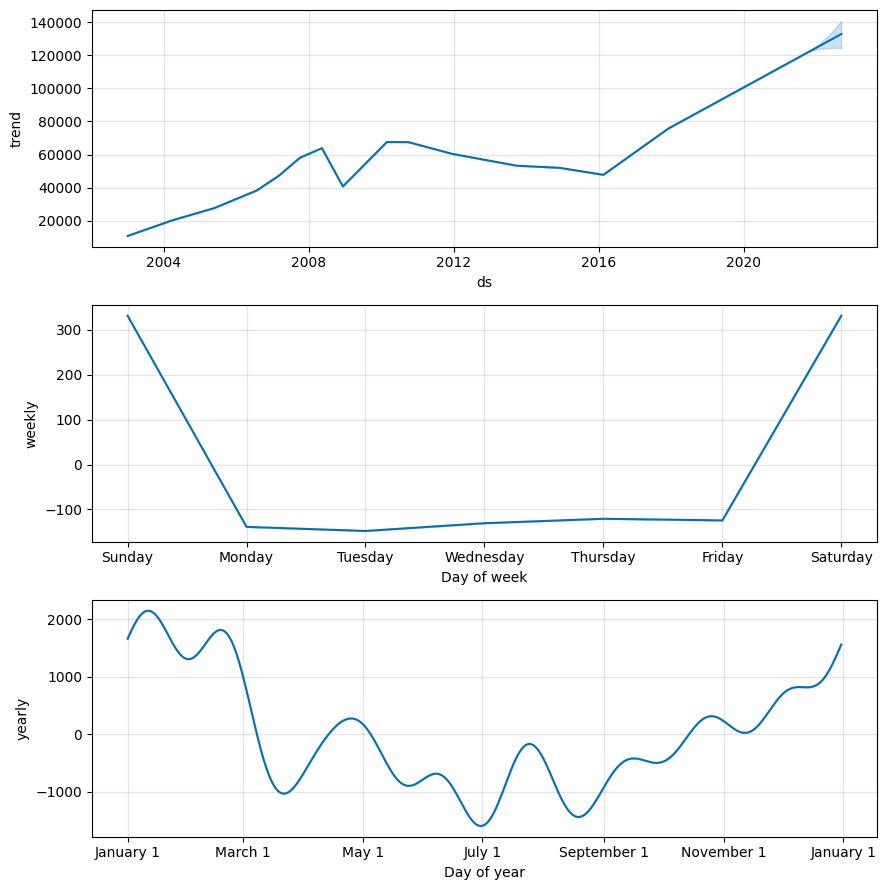

In [41]:
# Plotando os componentes
figure2 = m.plot_components(forecast)

#####Gráfico de previsão com dados de treino

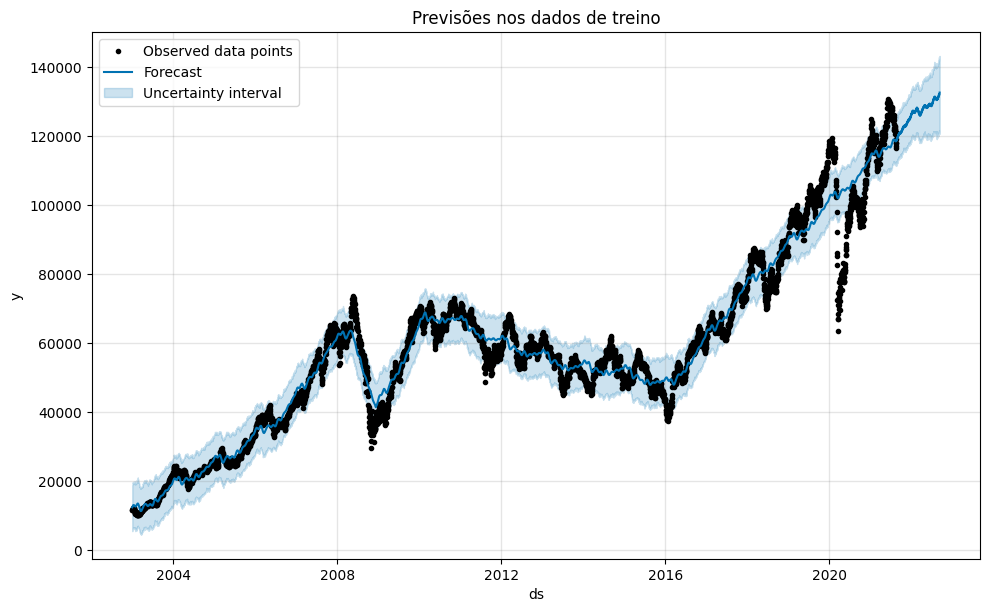

In [42]:
# configurando a área de plotagem
fig, ax = plt.subplots(1)
# alterando a altura
fig.set_figheight(6)
# alterando a largura
fig.set_figwidth(10)
# plotando o gráfico
fig = m.plot(forecast, ax=ax)
# definindo o título
plt.title('Previsões nos dados de treino');
plt.legend()

####Previsão

####Dataframe de resultados da previsão

In [43]:
# Previsões com os dados de teste
test_forecast = m.predict(test)
# Verificando os resultados das previsões com os dados de teste
test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
379,2023-03-01,139409.055626,123192.952360,158080.777428
380,2023-03-02,139318.614342,123926.134264,156477.025705
381,2023-03-03,139208.830566,123178.667666,157457.202116
382,2023-03-06,138857.771341,123792.703647,157253.068113
383,2023-03-07,138736.043190,123641.905514,157421.193941
384,2023-03-08,138643.255256,122757.512515,155180.339382
385,2023-03-09,138547.299239,122543.542006,156415.410118


#####Gráfico de previsão com dados de teste

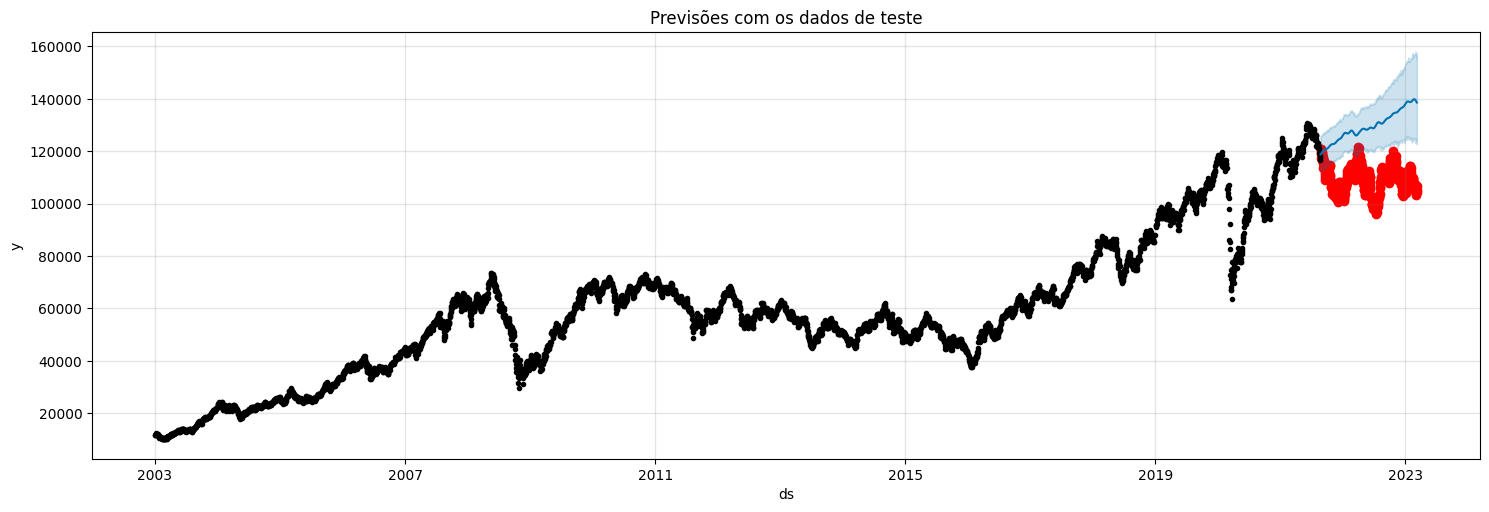

In [44]:
# configurando a área de plotagem
fig, ax = plt.subplots(1)
# alterando a altura
fig.set_figheight(5)
# alterando a largura
fig.set_figwidth(15)
# adicionando os dados de teste
ax.scatter(test.ds, test['y'], color='r')
# plotando o gráfico
fig = m.plot(test_forecast, ax=ax)
# definindo o título
plt.title('Previsões com os dados de teste');

#####Gráfico treinamento versus previsão

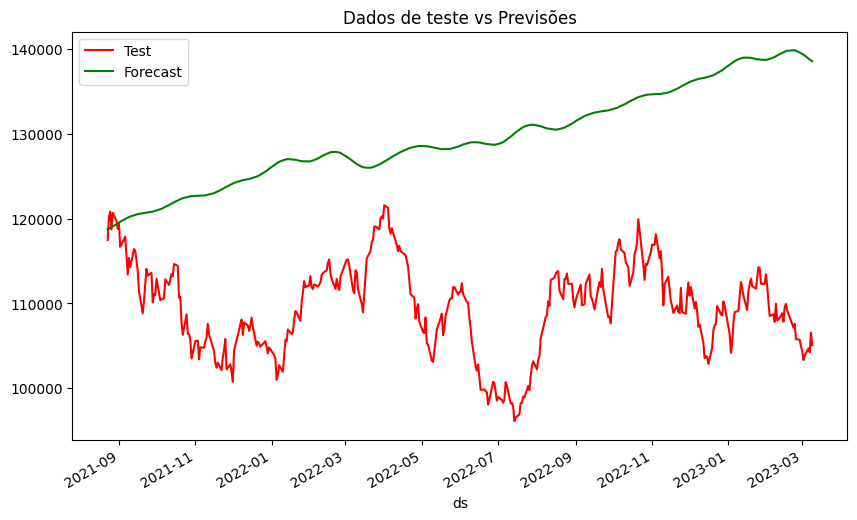

In [45]:
# configurando a área de plotagem
f, ax = plt.subplots(figsize=(14,5))
# alterando a altura
f.set_figheight(6)
# alterando a largura
f.set_figwidth(10)
# plotando o gráfico com dados de teste
test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
# plotando o gráfico com os dados previstos
test_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
# definindo o título
plt.title('Dados de teste vs Previsões');

##### MAPE inicial

In [46]:
mape = mean_absolute_percentage_error(test['y'],test_forecast['yhat'])
print("MAPE",round(mape,4))

MAPE 117.6413


####Validação cruzada

A validação cruzada é uma técnica para avaliar a capacidade de generalização de um modelo, a partir de um conjunto de dados. Basicamente  a ténica consiste em dividir os dados em várias partições e treina vários algoritmos nessas partições.
Essa técnica melhora a robustez do modelo mantendo os dados do processo de treinamento. Além de melhorar o desempenho em observações não vistas, em ambientes com restrições de dados, pode ser uma ferramenta eficiente para treinar modelos com um conjunto de dados menor.
Fonte: https://learn.microsoft.com/pt-br/dotnet/machine-learning/how-to-guides/train-machine-learning-model-cross-validation-ml-net

#####Cenário

Nossa empresa deseja deseja um modelo capaz de prever os preços das ações diáriamente e planeja executar o modelo no início de cada semestres(180 dias). Inicialmente iremos testar a acuracidade do modelo com 2 anos de dados (730 dias) e  utilizar a validação cruzada para identificar o melhor horizonte de previsão para nosso modelo

Desta forma temos seguintes informações:

*   Horizonte= 1-365 dias
*   Periodo = 180 dias
*   Inicial= 730 dias

INFO:prophet:Making 32 forecasts with cutoffs between 2005-05-11 00:00:00 and 2020-08-20 00:00:00


  0%|          | 0/32 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzxic7jw/rprcsqpt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzxic7jw/tx2bbl7f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24448', 'data', 'file=/tmp/tmpbzxic7jw/rprcsqpt.json', 'init=/tmp/tmpbzxic7jw/tx2bbl7f.json', 'output', 'file=/tmp/tmpbzxic7jw/prophet_model935ywequ/prophet_model-20230828004829.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:48:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:48:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzxic7jw/430omzub.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzxic7jw/rmdnnm6j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

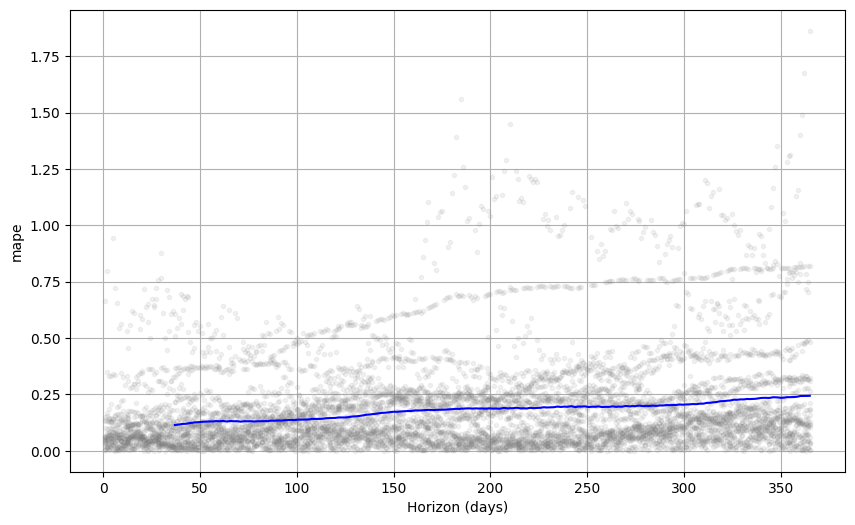

In [47]:
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')

fig = plot_cross_validation_metric(df_cv, metric='mape')

#####Dataframe de resultados da previsão

In [48]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,9.682984e+07,9840.215434,6649.267675,0.114071,0.067078,0.111083,0.377848
1,38 days,9.942193e+07,9971.054692,6733.715629,0.114959,0.067913,0.112213,0.376582
2,39 days,1.024711e+08,10122.800100,6825.356161,0.116091,0.068185,0.113332,0.374503
3,40 days,1.059510e+08,10293.249935,6914.623923,0.117658,0.068382,0.114457,0.377105
4,41 days,1.092321e+08,10451.417476,7005.836957,0.119079,0.069382,0.115685,0.375696


#####Gráfico MAPE Validação Cruzada

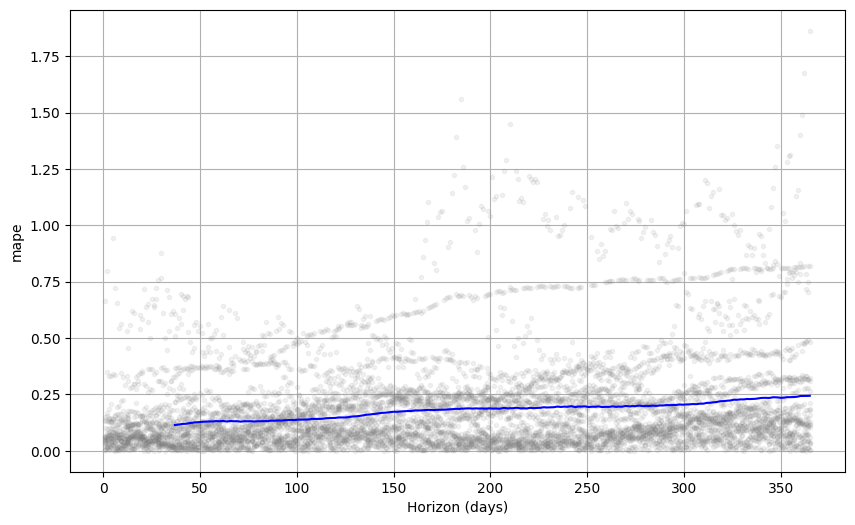

In [49]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [50]:
maxValues = df_p["mape"].min()
mape_valid_cruzada = df_p[df_p['mape'] == maxValues]
mape_valid_cruzada= mape_valid_cruzada.drop(columns=["mse","rmse", "mae", "smape","coverage","mdape"])

In [51]:
mape_valid_cruzada

,horizon,mape
0,37 days,0.114071
